In [1]:
# Librairies
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO, BytesIO
import os
import time
 
# image
from PIL import Image,ImageOps,ImageFilter

# Fonctions pyspark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, IntegerType, DoubleType, DataType, FloatType
from pyspark.ml.image import ImageSchema
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.sql.functions import col, pandas_udf, PandasUDFType

# Librairie pour se connecter au service S3 d'AWS
import boto3

# transfer learning pour l'extraction des features
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import warnings
warnings.simplefilter(action='ignore')

2022-06-19 23:53:07.661384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-19 23:53:07.661421: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Fonctions

In [2]:
def load_data(folder):
    
    """
    Retourne un dataFrame pyspark avec comme colonne la liste des chemins d'accès
    de toutes les images se trouvant le dossier folder
    """

    # Initialisation du temps de calcul
    start_time = time.time()
    
    lst_path =  []
    
    # connexion en local ou sur AWS
    if local == 'True':

        sub_folders = os.listdir(folder)
        print(sub_folders)

        for f in sub_folders:

            lst_categ = os.listdir(folder + f)

            for file in lst_categ:
                lst_path.append(folder + f + "/" + file)
    else :
        # Connexion à l'espace de stockage S3 d'AWS
        key=open('rootkey.txt','r')
        wrd=key.read()
        ID=str(wrd).split('\n')[0]
        PW=str(wrd).split('\n')[1]
        session = boto3.Session(aws_access_key_id=ID,
                                aws_secret_access_key=PW)
        s3_client = session.client(service_name='s3', region_name="us-east-1")
    


        prefix = 'data'
        sub_folders = s3_client.list_objects_v2(Bucket="ntv-p8", Prefix=prefix)

        for key in sub_folders["Contents"]:

            file = key["Key"]
            file = file.replace(prefix + "/", "")
            lst_path.append(folder + file)

    print("Nombre d'images chargées :", len(lst_path))
    
    # Création d'un RDD à partit de la liste des chemins d'accès aux images
    rdd = sc.parallelize(lst_path)
    row_rdd = rdd.map(lambda x: Row(x))
    
    # Création d'un dataFrame pyspark à partir d'un RDD
    df = spark.createDataFrame(row_rdd, ["path_img"])

    # Affichage du temps de calcul
    print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))

    return df

In [3]:
def extract_categ(path):
    
    """
    Retourne le nom du dossier dans lequel se trouve l'image,
    qui correspond au nom du type de fruits.
    """
    
    list_file = path.split("/")
    categ = list_file[-2]
    
    return categ

In [4]:
def preprocess_image(img_path):


    # Traitement en mode local
    if local == 'True':
        
        # fonction renvoie le même chemin d'accès
        def get_path(img_path):
            return img_path


    # Traitement en mode AWS
    else:
        
        # l'accès à S3 via la librairie boto3
        def get_path(img_path):
            key=open('rootkey.txt','r')
            wrd=key.read()
            ID=str(wrd).split('\n')[0]
            PW=str(wrd).split('\n')[1]
            session = boto3.Session(aws_access_key_id=ID,
                                aws_secret_access_key=PW)
            
            img_path = img_path.replace("s3://ntv-p8/", "")
            s3 = session.resource("s3", region_name='us-east-1')
            bucket = s3.Bucket("ntv-p8")
            object = bucket.Object(img_path)
            response = object.get()
            stream = response['Body']
            return stream

        
    # Ouvre l'image via la librairie pillow et prétraiter l'image
    def preprocessing(img_path):
        
        img = Image.open(img_path).resize([20, 20])
        img = ImageOps.autocontrast(img, cutoff=1)
        img = ImageOps.equalize(img, mask = None) 
        image=img.filter(ImageFilter.GaussianBlur(radius=1))
        return image

    image = preprocessing(get_path(img_path))
    
    return image

In [5]:
def model_fn():
    """
    Retourne un modèle ResNet50 avec la couche supérieure enlevée (fully-connected) et 
    des pondérations en broadcast déjà pré-entraînés. 
    On retire la couche supérieure car c'est celle qui permet de faire une classification, or 
    ici on se sert du modéle pour extraire des features.
    
    Pooling = "avg" est utilisé pour réduire le nombre de caractéristiques à 2048
    """

    model = ResNet50(weights= None, include_top=False, pooling='avg')
    #on ajoute les pondérations
    model.set_weights(bc_model_weights.value)
    
    return model


  
def featurize_series(model, content_series):
    """
    Retourne un pd.Series des features de l'image
    """
    def preprocess(img_path):
        result = preprocess_input(img_to_array(preprocess_image(img_path)))
        return result
                    
    input = np.stack(content_series.map(preprocess))
  # Extraction des features des images
    preds = model.predict(input)
                     
  # Pour certaines couches, les caractéristiques de sortie sont des tensors multidimensionnels
  # On aplatit les caractéristiques de tensors en vecteurs pour faciliter le stockage dans les dataframes Spark
  # la fonction flatten() envoie une copie du tableau réduit à une seule dimension 
    output = [p.flatten() for p in preds]
    return pd.Series(output)  

@pandas_udf(ArrayType(FloatType()), PandasUDFType.SCALAR_ITER)

def featurize_udf(content_series_iter):
    '''
    Cette méthode est un Itérateur Scalaire (pandas UDF signifiant User-Defined Functions) qui complète
    la fonction de featurisation.
    Cela renvoie une colonne Spark DataFrame de type ArrayType(FloatType).
  
    param content_series_iter : Cet argument est un itérateur sur des lots de données, où chaque lot
    est une série de données d'images pandas.
    '''
    
  # Avec les pandas UDF Scalar Iterator, on peut charger le modèle une fois et le réutiliser ensuite
  # pour plusieurs lots de données. Cela permet d'amortir les frais liés au chargement de grands modèles.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

In [6]:
### Réduction dimensionnelle des images
def reduction_dimension(df):
 
    # Les données images sont converties au format vecteur dense
    ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
    df = df.withColumn('features', ud_f('features'))
    
    # Mise à l'échelle
    standardizer = StandardScaler(inputCol="features", outputCol="feature_scaler",withStd=True, withMean=True)
    model_std = standardizer.fit(df)
    df = model_std.transform(df)
 
    # Recherche nb de composante
    num_components = 1000
    pca = PCA(k = num_components,
            inputCol="feature_scaler", 
              outputCol="features_pca")
 
    reduc = pca.fit(df)
    variance = reduc.explainedVariance
 
    # visuel
    plt.plot(np.arange(len(variance))+1, variance.cumsum(),c="red",marker='o')
    plt.xlabel("Nb de composantes")
    plt.ylabel("% variance")
    plt.show(block=False)
 
    def nb_comp ():
        for i in range(500):
            a = variance.cumsum()[i]
            if a >= 0.95:
                print("{} composantes principales expliquent au moins 95% de la variance totale".format(i))
                break
          
        return i
 
    n_comp=nb_comp()
 
    # Réduction de dimention
    pca = PCA(k=n_comp, inputCol='feature_scaler', outputCol='feature_reduit')
    model_pca = pca.fit(df)
    df = model_pca.transform(df)
 
    return df

In [7]:
# Ecrit les résultats en mode parquet

def save_data(df):
    # Initialisation du temps de calcul
    start_time = time.time()
    if local == 'True':
        df_csv=df.toPandas()
        df_csv.to_csv('results.csv')
    else :
        key=open('rootkey.txt','r')
        wrd=key.read()
        ID=str(wrd).split('\n')[0]
        PW=str(wrd).split('\n')[1]
        session = boto3.Session(aws_access_key_id=ID,
                                aws_secret_access_key=PW)
        df_csv=df.toPandas()
        csv_buffer = StringIO()
        df_csv.to_csv(csv_buffer)
        s3_client =session.client(service_name='s3', region_name="us-east-1")
        s3_client.put_object(Body=csv_buffer.getvalue(),Bucket="ntv-p8",Key='results')
    # Affichage du temps de calcul
    print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))

# Exécuter

In [8]:
# Démarre la session Spark
sc = SparkContext.getOrCreate()
sc.setLogLevel('ERROR')
spark = SparkSession.builder.appName("P8").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/19 23:53:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

---Liste des images---
Nombre d'images chargées : 546


Temps d'execution 4.37 secondes
+-----------------------------------+
|path_img                           |
+-----------------------------------+
|s3://ntv-p8/data/apple_6/r0_103.jpg|
|s3://ntv-p8/data/apple_6/r0_107.jpg|
|s3://ntv-p8/data/apple_6/r0_11.jpg |
|s3://ntv-p8/data/apple_6/r0_111.jpg|
|s3://ntv-p8/data/apple_6/r0_115.jpg|
+-----------------------------------+
only showing top 5 rows

----Extraction des catégories images-----
Temps d'execution 0.08 secondes


+-----------------------------------+-------+
|path_img                           |categ  |
+-----------------------------------+-------+
|s3://ntv-p8/data/apple_6/r0_103.jpg|apple_6|
|s3://ntv-p8/data/apple_6/r0_107.jpg|apple_6|
|s3://ntv-p8/data/apple_6/r0_11.jpg |apple_6|
|s3://ntv-p8/data/apple_6/r0_111.jpg|apple_6|
|s3://ntv-p8/data/apple_6/r0_115.jpg|apple_6|
+-----------------------------------+-------+
only showing top 5 rows

---Chargement des images---
Temps d'execution 0.03 secondes


2022-06-19 23:53:41.418652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-19 23:53:41.418702: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-19 23:53:41.418728: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-83-19.ec2.internal): /proc/driver/nvidia/version does not exist
2022-06-19 23:53:41.419991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


+--------------------+-------+--------------------+
|            path_img|  categ|    preprossed_image|
+--------------------+-------+--------------------+
|s3://ntv-p8/data/...|apple_6|[255, 255, 255, 2...|
|s3://ntv-p8/data/...|apple_6|[255, 255, 255, 2...|
|s3://ntv-p8/data/...|apple_6|[255, 255, 255, 2...|
|s3://ntv-p8/data/...|apple_6|[255, 255, 255, 2...|
|s3://ntv-p8/data/...|apple_6|[255, 255, 255, 2...|
+--------------------+-------+--------------------+
only showing top 5 rows

---Extraction des features---
Temps d'execution 3.23 secondes


2022-06-19 23:54:23.306587: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-19 23:54:23.306624: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-19 23:54:25.268053: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-19 23:54:25.268090: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-19 23:54:25.268112: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-83-19.ec2.internal): /proc/driver/nvidia/version does not exist
2022-06-19 23:54:25.268322: I tensorflow/core/pl

+--------------------+---------------+--------------------+--------------------+
|            path_img|          categ|    preprossed_image|            features|
+--------------------+---------------+--------------------+--------------------+
|s3://ntv-p8/data/...|cabbage_white_1|[255, 255, 255, 2...|[0.0, 3.8330007, ...|
|s3://ntv-p8/data/...|        apple_6|[255, 255, 255, 2...|[0.0, 5.48434, 0....|
|s3://ntv-p8/data/...|        apple_6|[255, 255, 255, 2...|[0.0, 9.448408, 0...|
|s3://ntv-p8/data/...|        apple_6|[255, 255, 255, 2...|[0.0, 0.5607046, ...|
|s3://ntv-p8/data/...|        apple_6|[255, 255, 255, 2...|[0.0, 0.9272784, ...|
+--------------------+---------------+--------------------+--------------------+
only showing top 5 rows

---Réduction dimmensionnelle---


2022-06-19 23:54:48.478514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-19 23:54:48.479253: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-19 23:54:48.574153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-19 23:54:48.574200: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-19 23:54:50.478942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022

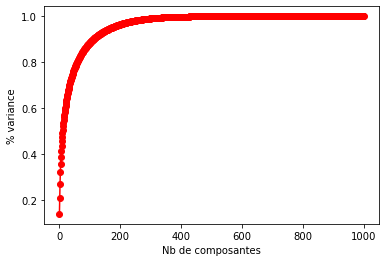

171 composantes principales expliquent au moins 95% de la variance totale


5/5 [==============================] - 2s 75ms/step
2022-06-19 23:59:54.939807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-19 23:59:54.940331: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-20 00:00:01.726951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-20 00:00:01.727483: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-20 00:00:01.727730: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-83-19.ec2.internal): /proc/driver/nvidia/version does not ex

Temps d'execution 444.38 secondes


5/5 [==============================] - 1s 52ms/step                 (0 + 1) / 


+--------------------+---------------+--------------------+--------------------+--------------------+
|            path_img|          categ|    preprossed_image|            features|      feature_reduit|
+--------------------+---------------+--------------------+--------------------+--------------------+
|s3://ntv-p8/data/...|cabbage_white_1|[255, 255, 255, 2...|[0.0,3.8330006599...|[24.8429349809501...|
|s3://ntv-p8/data/...|        apple_6|[255, 255, 255, 2...|[0.0,5.4843401908...|[6.72491747229549...|
|s3://ntv-p8/data/...|        apple_6|[255, 255, 255, 2...|[0.0,9.4484081268...|[11.8238296691685...|
|s3://ntv-p8/data/...|        apple_6|[255, 255, 255, 2...|[0.0,0.5607045888...|[4.53909093375285...|
|s3://ntv-p8/data/...|        apple_6|[255, 255, 255, 2...|[0.0,0.9272783994...|[3.77244666109634...|
+--------------------+---------------+--------------------+--------------------+--------------------+
only showing top 5 rows

----Enregistrement----


2022-06-20 00:03:46.806357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-20 00:03:46.806937: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-20 00:03:46.807285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-20 00:03:46.807496: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-20 00:03:50.084687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022

Temps d'execution 86.23 secondes
Save on S3 done.
##############################


In [10]:
# Définis le chemin d'accès au dossier des images sur local ou cloud AWS
local = 'False'
folder = 's3://ntv-p8/data/'


print("---Liste des images---")
df = load_data(folder)
df.show(5, False)


print("----Extraction des catégories images-----")
start_time = time.time()
udf_categ = udf(extract_categ, StringType())
df = df.withColumn("categ", udf_categ('path_img'))
print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))
df.show(5, False)


print("---Chargement des images---")
start_time = time.time()
ud_f = udf(lambda x: np.asarray(preprocess_image(x)).flatten().tolist())
df = df = df.withColumn('preprossed_image', ud_f('path_img'))
print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))
df.show(5)


print("---Extraction des features---")
start_time = time.time()
model = ResNet50(include_top=False)    # Instanciation du modèle
bc_model_weights = sc.broadcast(model.get_weights()) # Permettre aux workers Spark d'accéder aux poids utilisés par le modèle
df = df.repartition(4).select(col("path_img"),
                              col("categ"),
                              col("preprossed_image"),
                              featurize_udf("path_img").alias("features"))
print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))
df.show(5)



print("---Réduction dimmensionnelle---")
start_time = time.time()
df = reduction_dimension(df)
df = df.select('path_img', 'categ', 'preprossed_image', 'features', 'feature_reduit')
print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))
df.show(5)


print('----Enregistrement----')
save_data(df)
if local == 'True':
    print('Save on local disk done.')
else:
    print('Save on S3 done.')
print('#'*30)